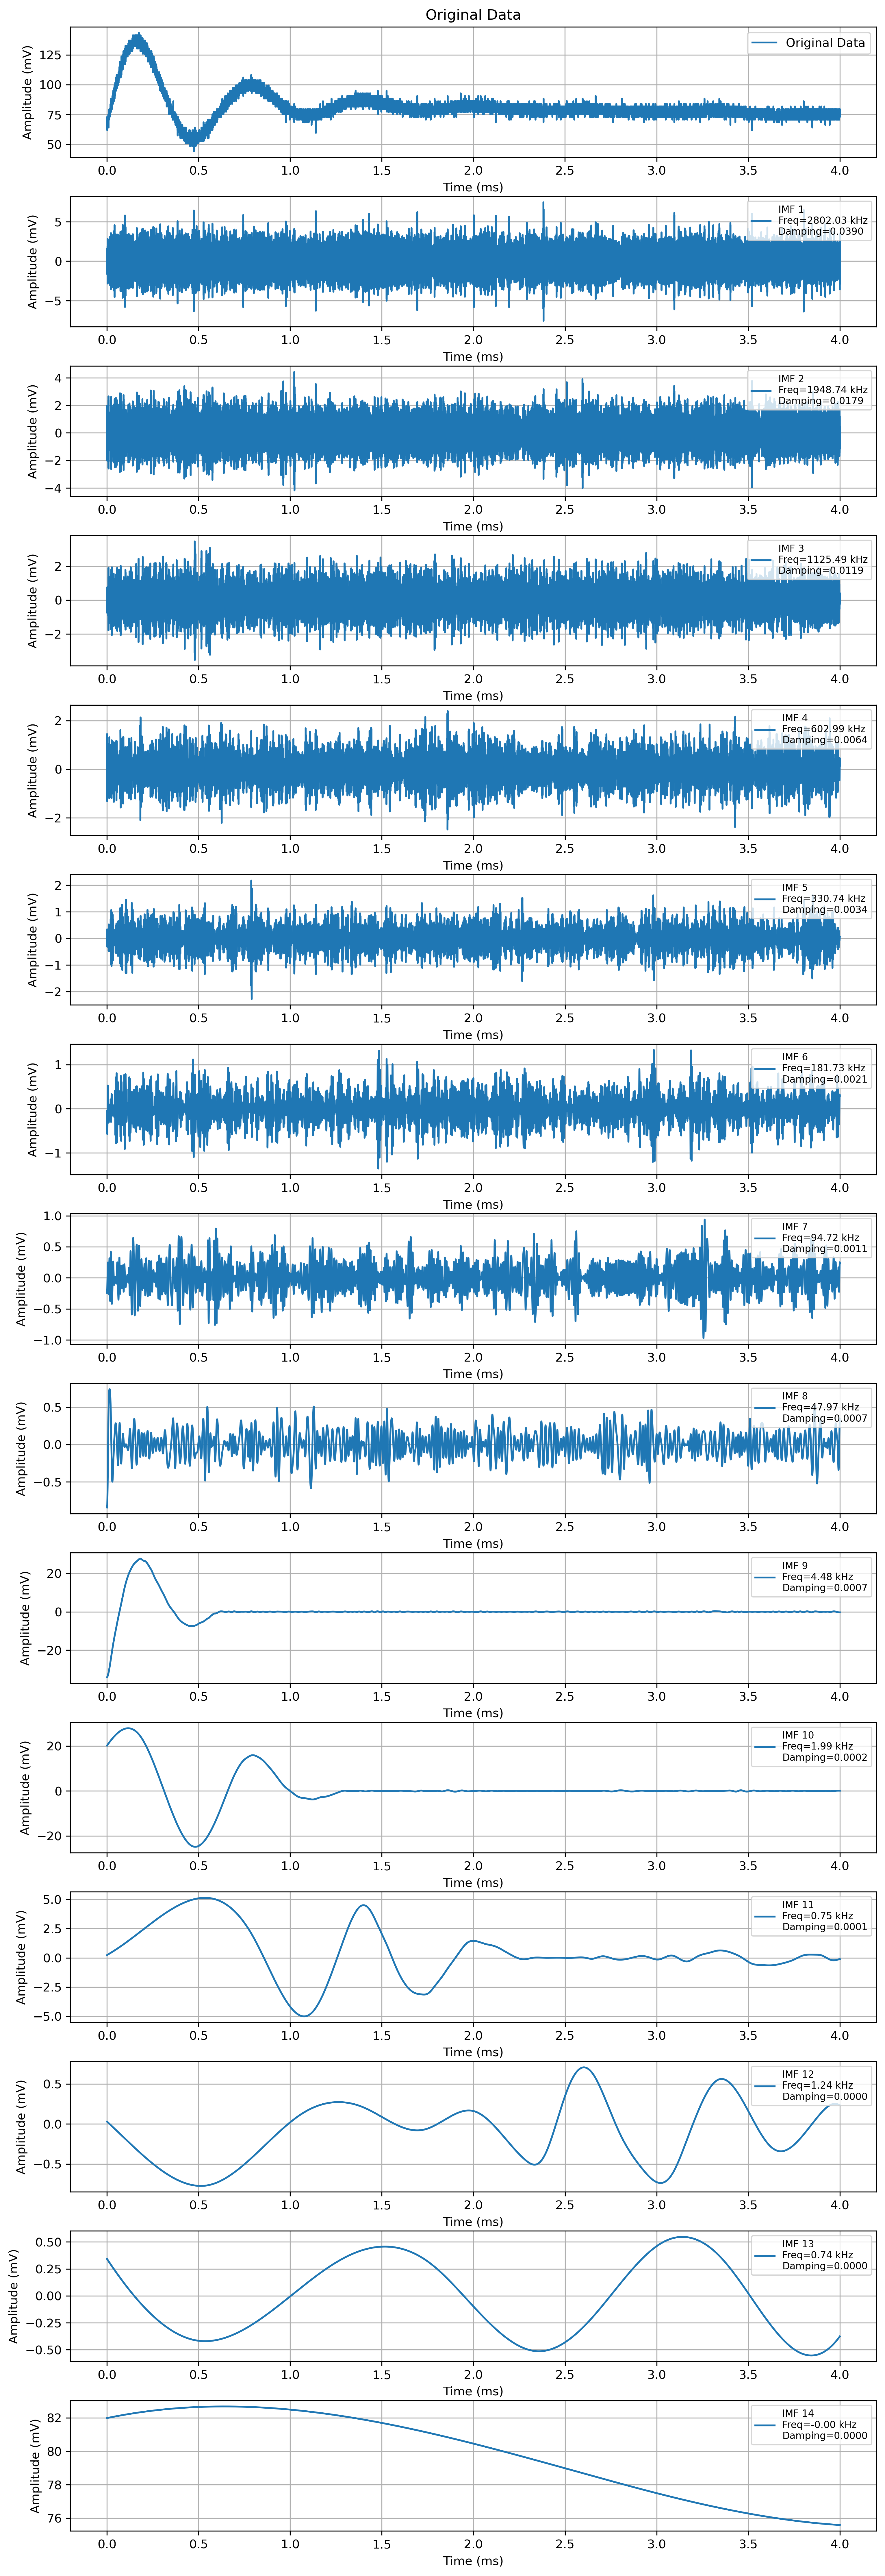

In [1]:
import numpy as np
import pandas as pd
from PyEMD import EMD
import matplotlib.pyplot as plt
from scipy.signal import hilbert

# 데이터 불러오기
file_path = 'C1Trace00001.csv'
data = pd.read_csv(file_path)
data.columns = ['Time', 'Voltage']

# 음수 시간 데이터 제거
filtered_data = data[data['Time'] >= 0].reset_index(drop=True)
time = filtered_data['Time'].to_numpy()
voltage_mV = filtered_data['Voltage'].to_numpy() * 1000  # 밀리볼트 변환
time_ms = time * 1000  # 밀리초 변환

# 4ms 구간으로 데이터 자르기
cut_off_time = 4
valid_indices = time_ms <= cut_off_time
time_ms = time_ms[valid_indices]
voltage_mV = voltage_mV[valid_indices]

# EMD 수행
emd = EMD()
imfs = emd.emd(voltage_mV)

# 그래프 설정
num_plots = len(imfs) + 1
fig, axes = plt.subplots(num_plots, 1, figsize=(12, min(2.5 * num_plots, 200)), dpi=300)

# 오리지널 데이터 플롯
axes[0].plot(time_ms, voltage_mV, label='Original Data')
axes[0].legend(loc='upper right')
axes[0].set_title('Original Data')
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Amplitude (mV)')
axes[0].grid(True)

# IMF 데이터 플롯
for i, imf in enumerate(imfs):
    analytic_signal = hilbert(imf)
    amplitude_envelope = np.abs(analytic_signal)
    instantaneous_phase = np.unwrap(np.angle(analytic_signal))
    instantaneous_frequency_kHz = np.diff(instantaneous_phase) / (2.0 * np.pi * np.diff(time_ms / 1000)) / 1000  # kHz 변환
    damping_ratio = np.mean(np.abs(np.diff(np.log(amplitude_envelope + 1e-10)))) / (2 * np.pi)

    axes[i + 1].plot(time_ms[:-1], imf[:-1], label=f'IMF {i+1}\nFreq={np.mean(instantaneous_frequency_kHz):.2f} kHz\nDamping={damping_ratio:.4f}')
    axes[i + 1].legend(loc='upper right', fontsize=8)
    axes[i + 1].set_xlabel('Time (ms)')
    axes[i + 1].set_ylabel('Amplitude (mV)')
    axes[i + 1].grid(True)

plt.subplots_adjust(hspace=0.3)
plt.show()
